# Compute changepoints for a dataset before and after transformation

In [2]:
import re
import h5py
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm.auto import tqdm
from collections import defaultdict
from toolz.curried import get, pluck
from toolz import groupby, valmap, compose, curry, partial
from aging.size_norm.data import clean
from aging.behavior.scalars import compute_scalars, im_moment_features
from sklearn.random_projection import GaussianRandomProjection
from scipy.ndimage import gaussian_filter, shift, rotate
from aging.plotting import (
    format_plots,
    PlotConfig,
    save_factory,
    figure,
    legend,
    IMG_KWARGS,
)

In [ ]:
data = joblib.load('/n/scratch3/users/w/wg41/aging-aligned-frames.p')

In [8]:
format_plots()
c = PlotConfig()
saver = save_factory(c.save_path / "size-normalization", tight_layout=False)

In [3]:
super_clean = partial(clean, height_thresh=14, tail_ksize=7, dilation_ksize=4)

def alignment_function(frame, recon_frame):
    frame = super_clean(frame)
    filt_frame = gaussian_filter(frame.astype("float32"), 13)
    filt_recon_frame = gaussian_filter(recon_frame.astype("float32"), 13)

    raw_peak = np.array(np.unravel_index(np.argmax(filt_frame), filt_frame.shape))
    recon_peak = np.array(
        np.unravel_index(np.argmax(filt_recon_frame), filt_recon_frame.shape)
    )

    translated = shift(frame, recon_peak - raw_peak)

    moments = im_moment_features(translated)
    if moments is None:
        return frame
    return rotate(
        translated, -np.rad2deg(moments["orientation"]), reshape=False
    ).astype("uint8")

In [5]:
def get_name(file):
    with h5py.File(file, "r") as h5f:
        return h5f["metadata/acquisition/SessionName"][()].decode()

In [6]:
recon_key = "win_size_norm_frames_v4"

In [7]:
@curry
def has_key(key, file):
    with h5py.File(file, "r") as h5f:
        return key in h5f

In [9]:
pattern = re.compile(r"(\d{1,2}[wm])")

folder = Path(
    "/n/groups/datta/win/longtogeny/data/ontogeny/version_05/all_data_pca/Ontogeny_males"
)
files = sorted(filter(has_key(recon_key), folder.glob("*.h5")))
names = list(map(get_name, files))
ages = [pattern.search(n).group(0) for n in names]
groups = groupby(get(0), list(zip(ages, files)))
groups = valmap(compose(list, pluck(1)), groups)

In [10]:
def zscore(arr):
    return (arr - arr.mean(axis=0, keepdims=True)) / arr.std(axis=0, keepdims=True)

## Plot 3 months

In [25]:
load_frames = 10_000

In [ ]:
file = groups["3m"][0]
with h5py.File(file, "r") as h5f:
    frames = h5f["frames"][:load_frames]
    transformed_frames = h5f[recon_key][:load_frames].astype("uint8")

frames = np.array(
    [alignment_function(f, rf) for f, rf in zip(tqdm(frames), transformed_frames)]
)

In [ ]:
mdl = GaussianRandomProjection(n_components=200, random_state=0)
proj = mdl.fit_transform(frames.reshape(len(frames), -1))
proj_t = mdl.transform(transformed_frames.reshape(len(transformed_frames), -1))

  0%|          | 0/10000 [00:00<?, ?it/s]

In [13]:
proj.shape

(10000, 200)

In [14]:
k = 5
sig = 3

In [15]:
proj_df = pd.DataFrame(zscore(zscore(proj).T).T, index=np.arange(len(proj)) / 30)
proj_df_smooth = (
    proj_df.rolling(sig * 4, win_type="gaussian", center=True).mean(std=sig).dropna()
)
squared_diff = np.square(proj_df_smooth.diff(k))

proj_t_df = pd.DataFrame(zscore(zscore(proj_t).T).T, index=np.arange(len(proj)) / 30)
proj_t_df_smooth = (
    proj_t_df.rolling(sig * 4, win_type="gaussian", center=True).mean(std=sig).dropna()
)
squared_diff_t = np.square(proj_t_df_smooth.diff(k))

cp = squared_diff.mean(axis="columns")
cp_t = squared_diff_t.mean(axis="columns")

In [16]:
# how many frames to plot
n_frames = 750

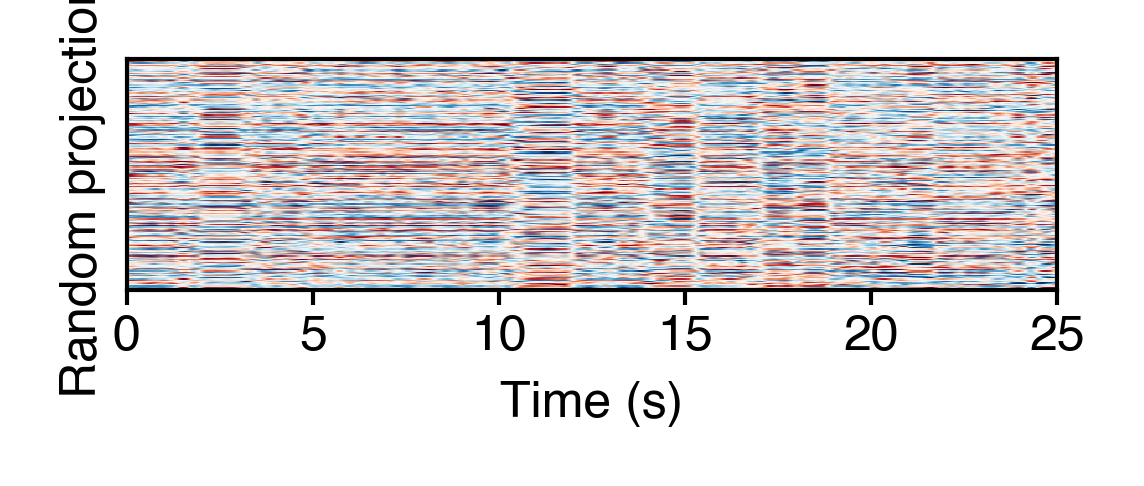

In [17]:
fig = figure(2, 0.5)
plt.imshow(
    proj_df_smooth.iloc[:n_frames].T,
    cmap="RdBu_r",
    vmin=-2,
    vmax=2,
    **IMG_KWARGS,
    extent=(0, n_frames / 30, 0, proj.shape[1])
)
ax = plt.gca()
ax.set(yticks=[], xlabel="Time (s)", ylabel="Random projections")
saver(fig, "rps-3m-raw");

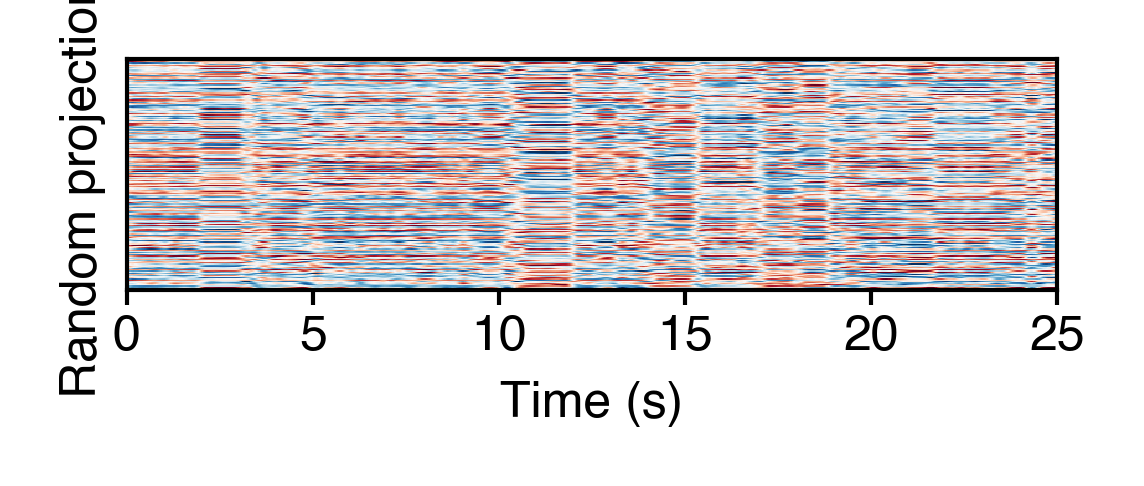

In [18]:
fig = figure(2, 0.5)
plt.imshow(
    proj_t_df_smooth.iloc[:n_frames].T,
    cmap="RdBu_r",
    vmin=-2,
    vmax=2,
    **IMG_KWARGS,
    extent=(0, n_frames / 30, 0, proj.shape[1])
)
ax = plt.gca()
ax.set(yticks=[], xlabel="Time (s)", ylabel="Random projections")
saver(fig, "rps-3m-transformed");

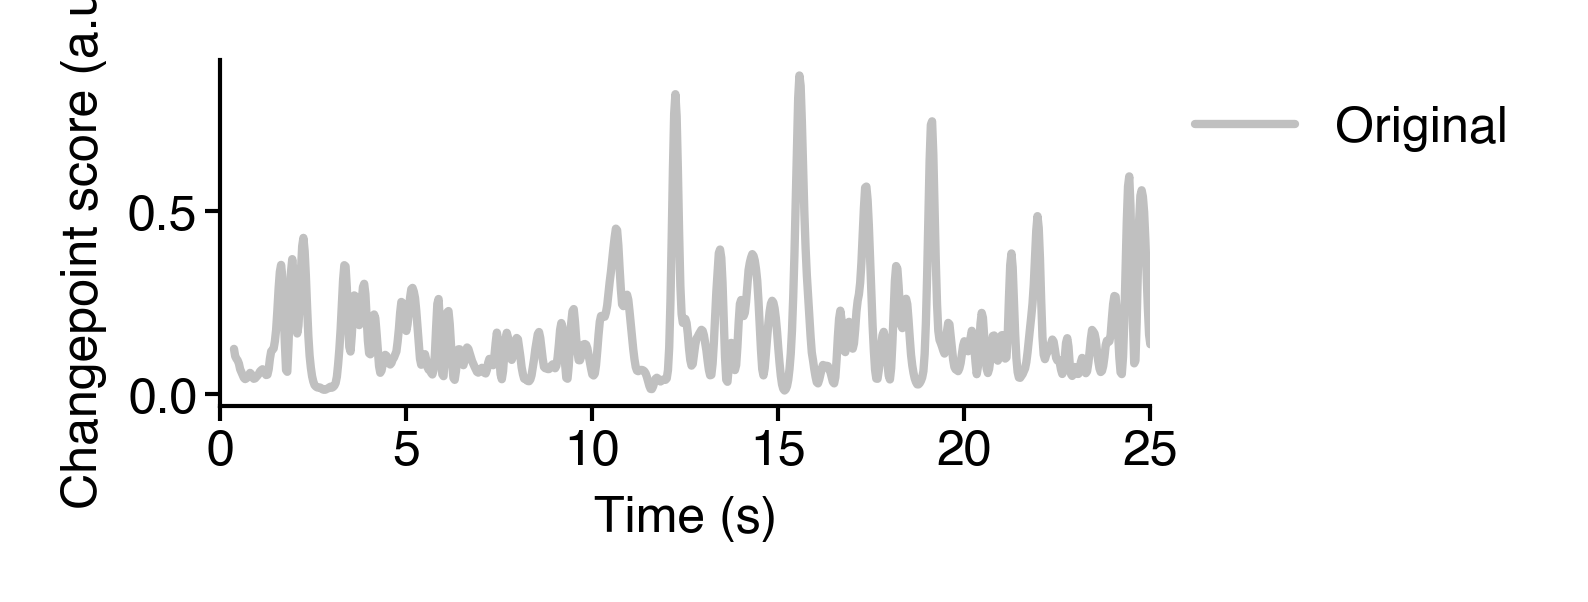

In [19]:
fig = figure(2, 0.75)
plt.plot(cp.iloc[:n_frames], color='silver', label='Original')
legend()
plt.ylabel("Changepoint score (a.u.)")
plt.xlabel("Time (s)")
plt.xlim(0, 25)
sns.despine()
saver(fig, 'cps-3m-orig');

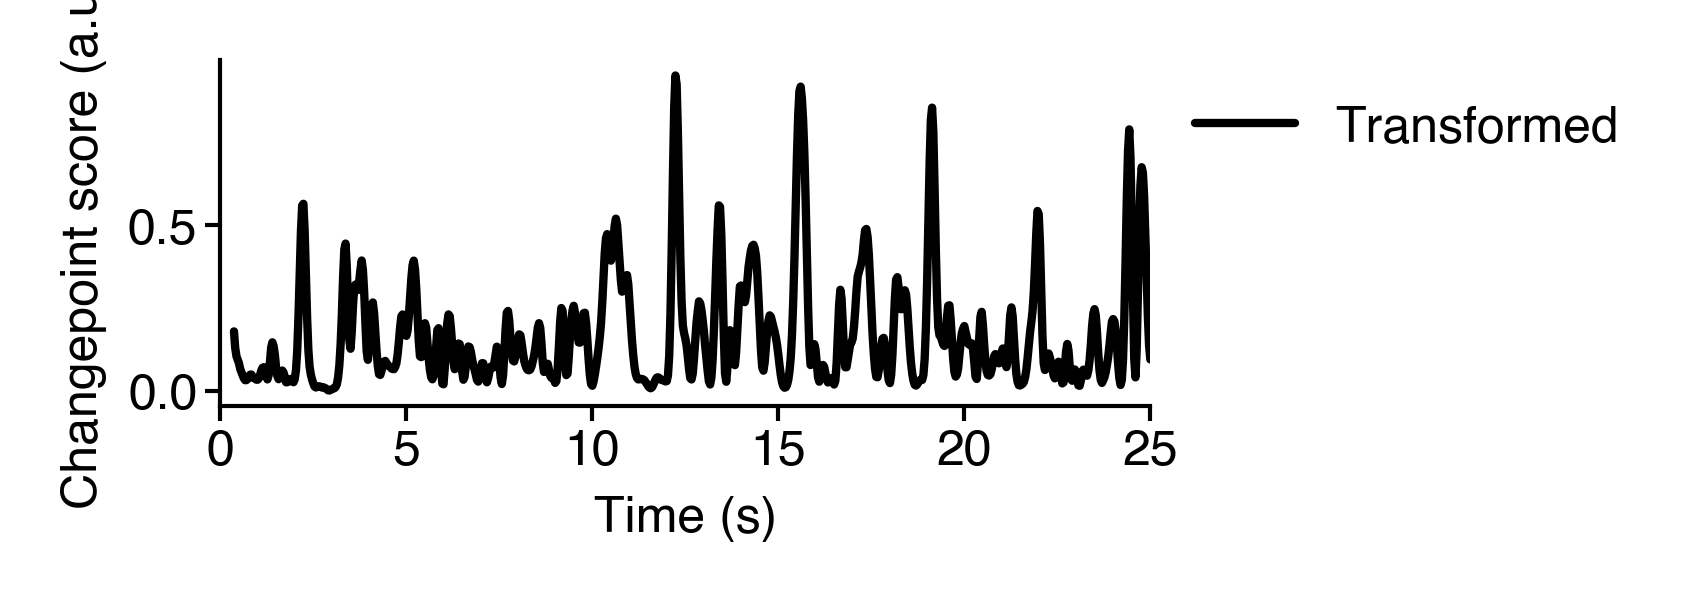

In [20]:
fig = figure(2, 0.75)
plt.plot(cp_t.iloc[:n_frames], color='k', label='Transformed')
legend()
plt.ylabel("Changepoint score (a.u.)")
plt.xlabel("Time (s)")
plt.xlim(0, 25)
sns.despine()
saver(fig, 'cps-3m-trans');

In [21]:
fig = figure(2, 0.75)
plt.plot(cp_t.iloc[:n_frames], color='k', label='Transformed')
plt.plot(cp.iloc[:n_frames], color='silver', label='Original')
legend()
plt.ylabel("Changepoint score (a.u.)")
plt.xlabel("Time (s)")
plt.xlim(0, 25)
sns.despine()
saver(fig, 'cps-3m');

In [22]:
cp.corr(cp_t)

0.9520465692801462

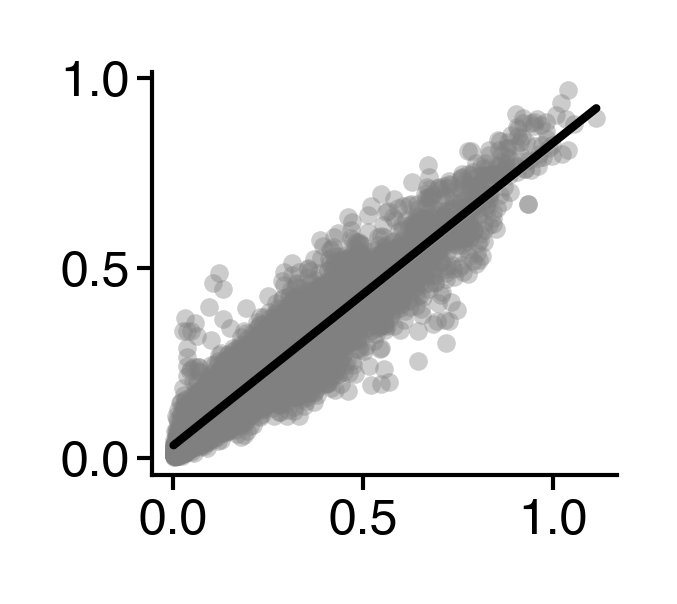

In [23]:
fig = figure(1, 1)
ax = sns.regplot(
    x=squared_diff_t.mean(axis="columns"),
    y=squared_diff.mean(axis="columns"),
    color="k",
    scatter_kws=dict(lw=0, alpha=0.4, s=5, color="gray"),
    line_kws=dict(lw=1),
)
ax.set_aspect("equal")
sns.despine()

## Another example

In [26]:
file = groups["18m"][1]
with h5py.File(file, "r") as h5f:
    frames = h5f["frames"][:load_frames]
    transformed_frames = h5f[recon_key][:load_frames].astype("uint8")

frames = np.array(
    [alignment_function(f, rf) for f, rf in zip(tqdm(frames), transformed_frames)]
)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [27]:
mdl = GaussianRandomProjection(n_components=200, random_state=0)
proj = mdl.fit_transform(frames.reshape(len(frames), -1))
proj_t = mdl.transform(transformed_frames.reshape(len(transformed_frames), -1))

In [28]:
proj_df = pd.DataFrame(zscore(zscore(proj).T).T, index=np.arange(len(proj)) / 30)
proj_df_smooth = (
    proj_df.rolling(sig * 4, win_type="gaussian", center=True).mean(std=sig).dropna()
)
squared_diff = np.square(proj_df_smooth.diff(k))

proj_t_df = pd.DataFrame(zscore(zscore(proj_t).T).T, index=np.arange(len(proj)) / 30)
proj_t_df_smooth = (
    proj_t_df.rolling(sig * 4, win_type="gaussian", center=True).mean(std=sig).dropna()
)
squared_diff_t = np.square(proj_t_df_smooth.diff(k))

cp = squared_diff.mean(axis="columns")
cp_t = squared_diff_t.mean(axis="columns")

In [29]:
fig = figure(2, 0.5)
plt.imshow(
    proj_df_smooth.iloc[:n_frames].T,
    cmap="RdBu_r",
    vmin=-2,
    vmax=2,
    **IMG_KWARGS,
    extent=(0, n_frames / 30, 0, proj.shape[1])
)
ax = plt.gca()
ax.set(yticks=[], xlabel="Time (s)", ylabel="Random projections")
saver(fig, "rps-18m-raw");

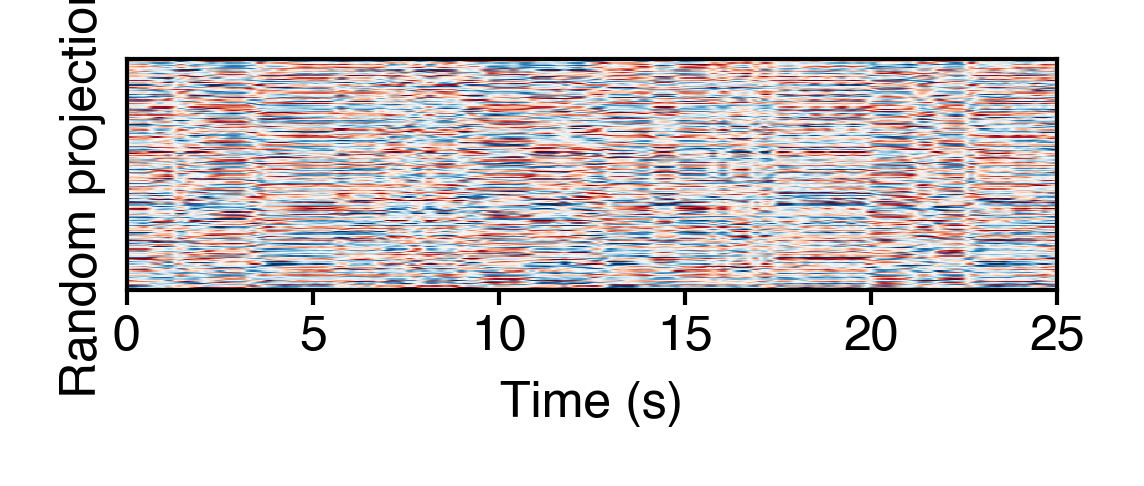

In [30]:
fig = figure(2, 0.5)
plt.imshow(
    proj_t_df_smooth.iloc[:n_frames].T,
    cmap="RdBu_r",
    vmin=-2,
    vmax=2,
    **IMG_KWARGS,
    extent=(0, n_frames / 30, 0, proj.shape[1])
)
ax = plt.gca()
ax.set(yticks=[], xlabel="Time (s)", ylabel="Random projections")
saver(fig, "rps-18m-transformed");

In [31]:
cp.corr(cp_t)

0.9207459190399636

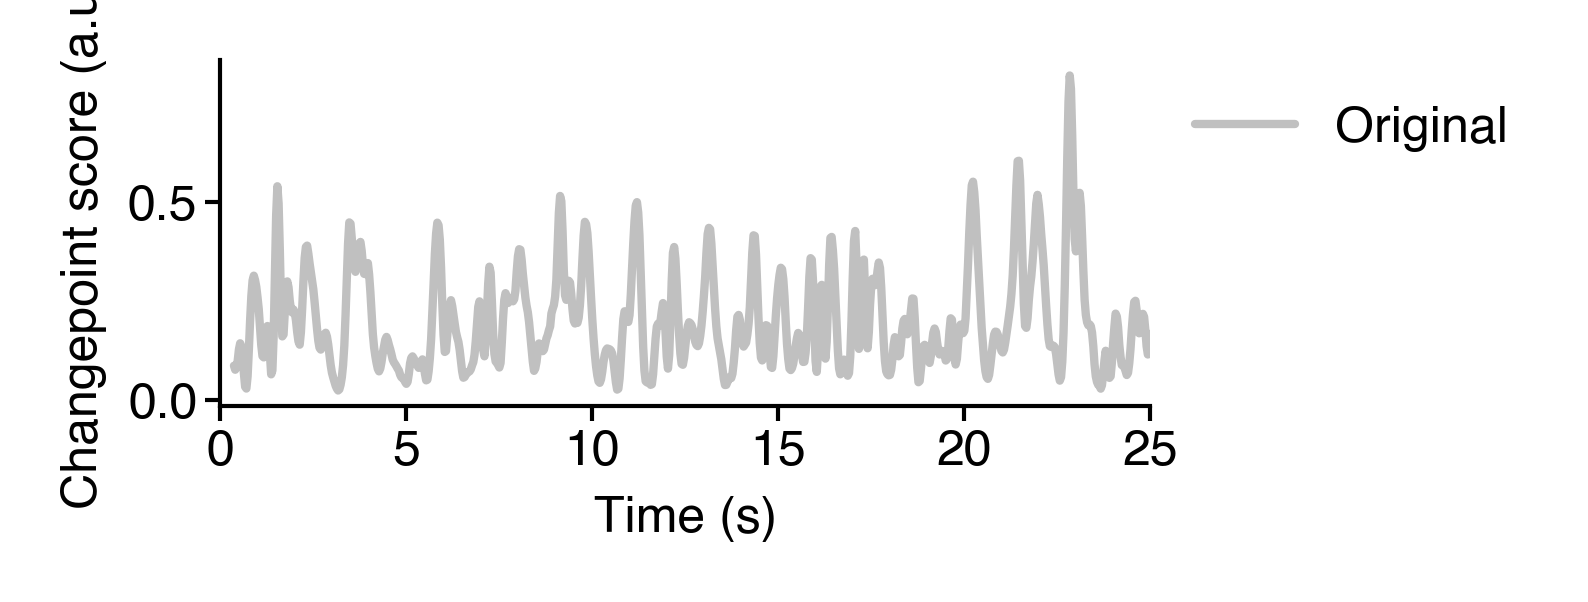

In [32]:
fig = figure(2, 0.75)
plt.plot(cp.iloc[:n_frames], color='silver', label='Original')
legend()
plt.ylabel("Changepoint score (a.u.)")
plt.xlabel("Time (s)")
plt.xlim(0, 25)
sns.despine()
saver(fig, 'cps-18m-orig');

In [33]:
fig = figure(2, 0.75)
plt.plot(cp_t.iloc[:n_frames], color='k', label='Transformed')
legend()
plt.ylabel("Changepoint score (a.u.)")
plt.xlabel("Time (s)")
plt.xlim(0, 25)
sns.despine()
saver(fig, 'cps-18m-trans');

In [34]:
fig = figure(2, 0.75)
plt.plot(cp_t.iloc[:n_frames], color='k', label='Transformed')
plt.plot(cp.iloc[:n_frames], color='silver', label='Original')
legend()
plt.ylabel("Changepoint score (a.u.)")
plt.xlabel("Time (s)")
plt.xlim(0, 25)
sns.despine()
saver(fig, 'cps-18m');

## Example for 3 weeks

In [35]:
file = groups["3w"][0]
with h5py.File(file, "r") as h5f:
    frames = h5f["frames"][:load_frames]
    transformed_frames = h5f[recon_key][:load_frames].astype("uint8")

frames = np.array(
    [alignment_function(f, rf) for f, rf in zip(tqdm(frames), transformed_frames)]
)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [36]:
mdl = GaussianRandomProjection(n_components=200, random_state=0)
proj = mdl.fit_transform(frames.reshape(len(frames), -1))
proj_t = mdl.transform(transformed_frames.reshape(len(transformed_frames), -1))

In [37]:
proj_df = pd.DataFrame(zscore(zscore(proj).T).T, index=np.arange(len(proj)) / 30)
proj_df_smooth = (
    proj_df.rolling(sig * 4, win_type="gaussian", center=True).mean(std=sig).dropna()
)
squared_diff = np.square(proj_df_smooth.diff(k))

proj_t_df = pd.DataFrame(zscore(zscore(proj_t).T).T, index=np.arange(len(proj)) / 30)
proj_t_df_smooth = (
    proj_t_df.rolling(sig * 4, win_type="gaussian", center=True).mean(std=sig).dropna()
)
squared_diff_t = np.square(proj_t_df_smooth.diff(k))

cp = squared_diff.mean(axis="columns")
cp_t = squared_diff_t.mean(axis="columns")

In [38]:
fig = figure(2, 0.5)
plt.imshow(
    proj_df_smooth.iloc[:n_frames].T,
    cmap="RdBu_r",
    vmin=-2,
    vmax=2,
    **IMG_KWARGS,
    extent=(0, n_frames / 30, 0, proj.shape[1])
)
ax = plt.gca()
ax.set(yticks=[], xlabel='Time (s)', ylabel='Random projections')
saver(fig, 'rps-3w-raw');

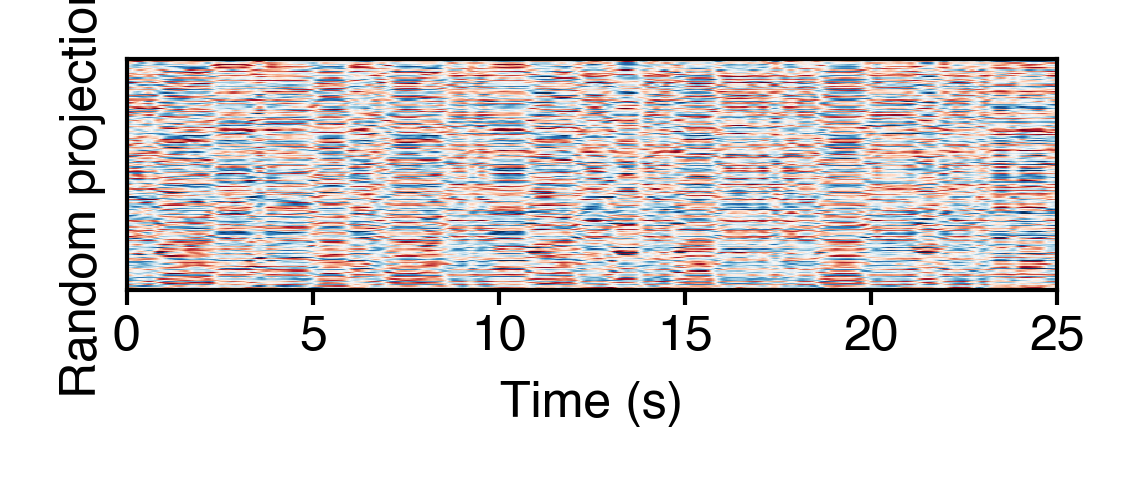

In [39]:
fig = figure(2, 0.5)
plt.imshow(
    proj_t_df_smooth.iloc[:n_frames].T,
    cmap="RdBu_r",
    vmin=-2,
    vmax=2,
    **IMG_KWARGS,
    extent=(0, n_frames / 30, 0, proj.shape[1])
)
ax = plt.gca()
ax.set(yticks=[], xlabel='Time (s)', ylabel='Random projections')
saver(fig, 'rps-3w-transformed');

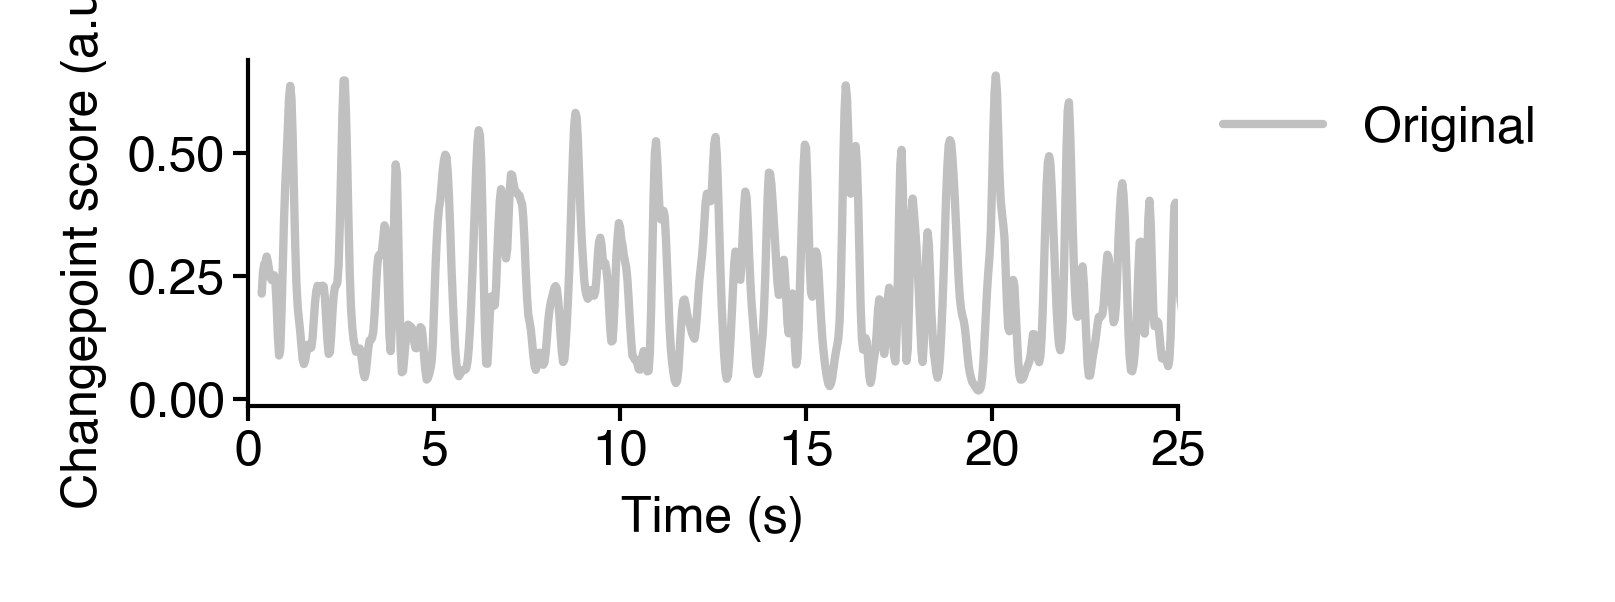

In [40]:
fig = figure(2, 0.75)
plt.plot(cp.iloc[:n_frames], color='silver', label='Original')
legend()
plt.ylabel("Changepoint score (a.u.)")
plt.xlabel("Time (s)")
plt.xlim(0, 25)
sns.despine()
saver(fig, 'cps-3w-orig');

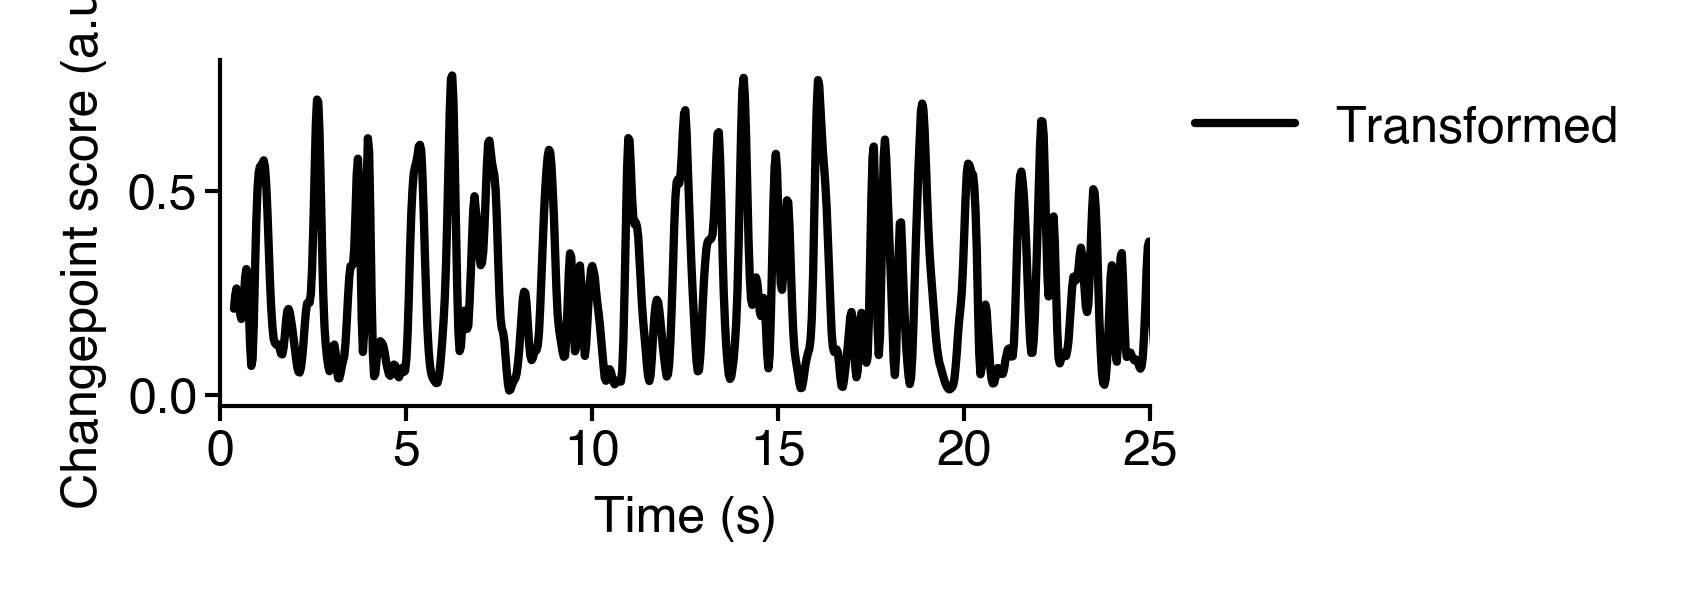

In [41]:
fig = figure(2, 0.75)
plt.plot(cp_t.iloc[:n_frames], color='k', label='Transformed')
legend()
plt.ylabel("Changepoint score (a.u.)")
plt.xlabel("Time (s)")
plt.xlim(0, 25)
sns.despine()
saver(fig, 'cps-3w-trans');

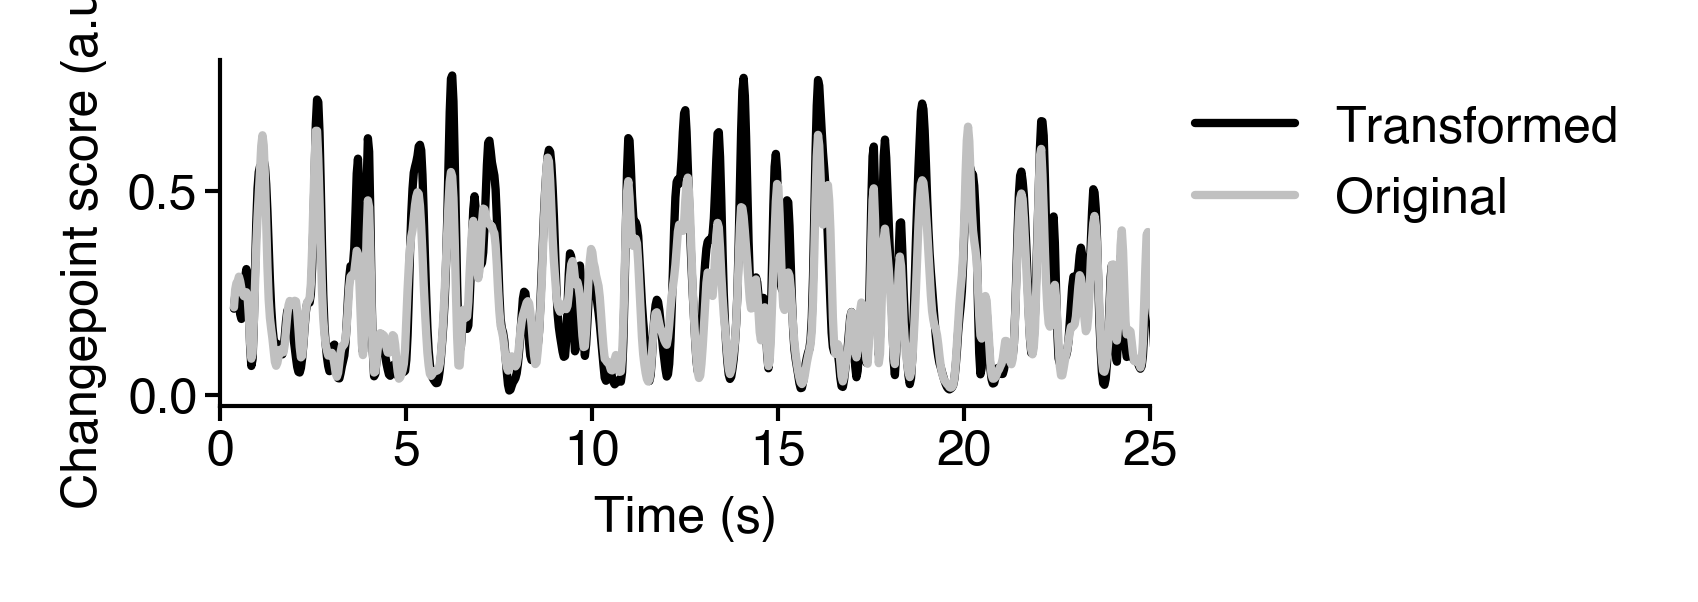

In [42]:
fig = figure(2, 0.75)
plt.plot(cp_t.iloc[:n_frames], color='k', label='Transformed')
plt.plot(cp.iloc[:n_frames], color='silver', label='Original')
legend()
plt.ylabel("Changepoint score (a.u.)")
plt.xlabel("Time (s)")
plt.xlim(0, 25)
sns.despine()
saver(fig, 'cps-3w');

In [43]:
cp.corr(cp_t)

0.9047513410387411

## Compute correlation between changepoint scores for all ages

In [44]:
k = 5
sig = 3

In [45]:
age_map = {
    "12m": 12 * 30 / 7,
    "18m": 18 * 30 / 7,
    "3w": 3,
    "5w": 5,
    "9w": 9,
    "7w": 7,
    "90w": 90,
    "22m": 22 * 30 / 7,
    "3m": 3 * 30 / 7,
    "6m": 6 * 30 / 7,
    "9m": 9 * 30 / 7,
}
age_map = valmap(int, age_map)

In [35]:
file = groups["3w"][0]
with h5py.File(file, "r") as h5f:
    frames = h5f["frames"][:load_frames]
    transformed_frames = h5f[recon_key][:load_frames].astype("uint8")

frames = np.array(
    [alignment_function(f, rf) for f, rf in zip(tqdm(frames), transformed_frames)]
)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
total_frames = 12_000
cp_dict = defaultdict(list)
for i in tqdm(range(16)):
    for age, v in tqdm(groups.items()):
        with h5py.File(v[i], "r") as h5f:
            frames = h5f["frames"][:total_frames]
            transformed_frames = h5f[recon_key][:total_frames].astype("uint8")

        frames = np.array(
            [
                alignment_function(f, rf)
                for f, rf in zip(frames, transformed_frames)
            ]
        )
        mdl = GaussianRandomProjection(n_components=200, random_state=0)
        proj = mdl.fit_transform(frames.reshape(len(frames), -1))
        proj_t = mdl.transform(transformed_frames.reshape(len(transformed_frames), -1))

        proj_df = pd.DataFrame(
            zscore(zscore(proj).T).T, index=np.arange(len(proj)) / 30
        )
        proj_df_smooth = (
            proj_df.rolling(sig * 4, win_type="gaussian", center=True)
            .mean(std=sig)
            .dropna()
        )
        squared_diff = np.square(proj_df_smooth.diff(k))

        proj_t_df = pd.DataFrame(
            zscore(zscore(proj_t).T).T, index=np.arange(len(proj)) / 30
        )
        proj_t_df_smooth = (
            proj_t_df.rolling(sig * 4, win_type="gaussian", center=True)
            .mean(std=sig)
            .dropna()
        )
        squared_diff_t = np.square(proj_t_df_smooth.diff(k))

        cp = squared_diff.mean(axis="columns")
        cp_t = squared_diff_t.mean(axis="columns")

        cp_dict[age_map[age]].append(cp.corr(cp_t))

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/12000 [00:00<?, ?it/s]

  0%|          | 0/12000 [00:00<?, ?it/s]

In [ ]:
cp_df = pd.DataFrame(cp_dict)
cp_df = cp_df.melt(var_name="Age", value_name="corr")

In [52]:
fig = figure(1, 2)
ax = sns.swarmplot(
    data=cp_df,
    y="corr",
    hue="Age",
    palette="crest_r",
    size=2.2,
    legend="full",
)
legend(ax, title="Age (weeks)")
ax.set(ylim=(0.5, 1), ylabel="Changepoint score correlation")
sns.despine()
saver(fig, "cps-correlation-vs-age-swarmplot");

/home/wg41/miniconda3/envs/aging/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 13.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


/home/wg41/miniconda3/envs/aging/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 13.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


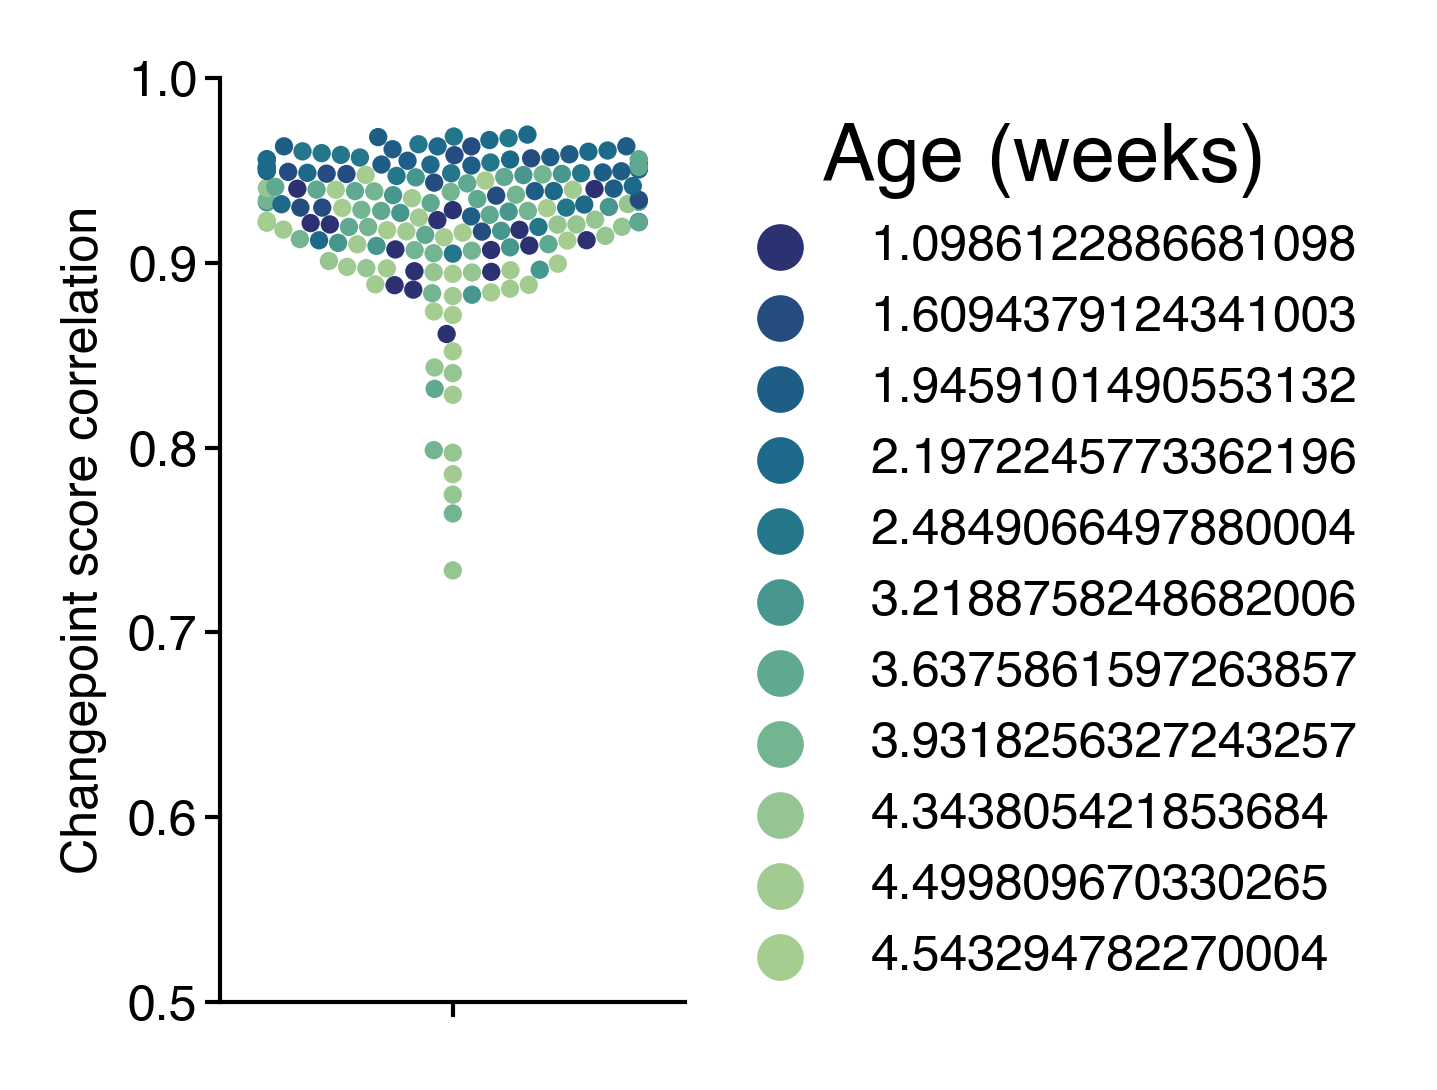

In [53]:
cp_df['log_age'] = np.log(cp_df['Age'])
fig = figure(1, 2)
ax = sns.swarmplot(
    data=cp_df,
    y="corr",
    hue="log_age",
    palette="crest_r",
    size=2.2,
    legend="full",
)
legend(ax, title="Age (weeks)")
ax.set(ylim=(0.5, 1), ylabel="Changepoint score correlation")
sns.despine()
saver(fig, "cps-correlation-vs-log_age-swarmplot");